In [1]:
import numpy as np
from matplotlib.pyplot import *
from tqdm import tqdm

from prospect.models.templates import TemplateLibrary
from prospect.models.transforms import tburst_from_fage
from astropy.cosmology import Planck13

import sys
sys.path.append('/home/samantha/Documents/REU/scripts/') # Use the absolute path to the directory
%pwd
from prospectFunctionsSFH import *

from prospect.plotting.sfh import parametric_sfr

In [2]:
TemplateLibrary['burst_sfh']

{'tburst': {'N': 1,
  'isfree': False,
  'init': 0.0,
  'units': 'Gyr',
  'prior': None,
  'depends_on': <function prospect.models.transforms.tburst_from_fage(tage=0.0, fage_burst=0.0, **extras)>},
 'fburst': {'N': 1,
  'isfree': False,
  'init': 0.0,
  'units': 'fraction of total mass formed in the burst',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)},
 'fage_burst': {'N': 1,
  'isfree': False,
  'init': 0.0,
  'units': 'time at wich burst happens, as a fraction of `tage`',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=1.0)}}

In [4]:
run_params = {}
run_params['zred'] = 3.548
run_params['mass'] = 1e8
run_params['logzsol'] = 0.0 # Solar metallicity
run_params['dust2'] = 0.0
run_params['sfh'] = 1 # tau model plus a constant component and a burst
run_params['tage'] = 1 # The age of the host (galaxy) in Gyrs
run_params['imf_type'] = 2 # (Kroupa 2001)
run_params['dust_type'] = 0
run_params['tau'] = .05 # The e-folding time for the SFH, range is 1e-1 to 1e2

run_params['add_burst'] = True
# run_params['tburst']
run_params['fburst'] = 0.1 # The fraction of mass formed in an instantaneous burst of star formation
run_params['fage_burst'] = 0.4 # The fraction of the host age at which the burst occurred.
run_params['tburst'] = tburst_from_fage(**run_params) # The age of the universe (age of the host) when the burst occurred

run_params['const'] =  0.8 - run_params['fburst']

run_params['trunc'] = True
run_params['sf_start'] = 0.2 # Start time of the SFH in Gyrs
run_params['sf_trunc'] = 0.9 # Trunctation time of the SFH in Gyrs. 0.0 => no trunctation
# run_params['sf_slope'] # For sfh=5, this is the slope of the SFR *after* time sf_trunc

obs = getObs()
sps = getSps(**run_params)

model = getModel(**run_params)

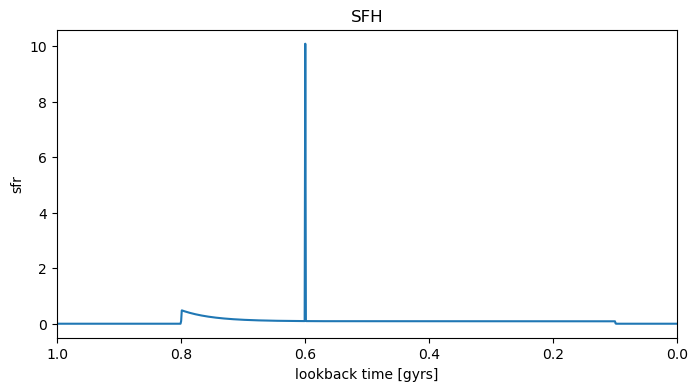

In [6]:
figure(figsize=(8,4))

times = np.linspace(0,run_params['tage'],1000)

sfrs = parametric_sfr(times=times,**run_params)
plot(times,sfrs)

xlabel('lookback time [gyrs]')
ylabel('sfr')

xlim([times[-1],times[0]])

title('SFH')

show()

In [3]:
figure(figsize=(16,8))

times = np.linspace(0,run_params['tage'],1000)

sfrs = parametric_sfr(times=times,**run_params)
plot(times,sfrs)

xlabel('lookback time [gyrs]')
ylabel('sfr')

xlim([times[-1],times[0]])

title('SFH')

show()

NameError: name 'run_params' is not defined

<Figure size 1600x800 with 0 Axes>

In [228]:
def model_function(add_burst=False, trunc=False, **extras):

    from prospect.models import SpecModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary['parametric_sfh']

    if add_burst:
        model_params.update(TemplateLibrary['burst_sfh'])
        model_params['const'] = {'N': 1, 'isfree': False, 'init': 0.0, 'units': 'Solar Masses per year'}
        if trunc:
            model_params['sf_start'] = {'N': 1, 'isfree': False, 'init': 0.0, 'units': 'Gyrs'}
            model_params['sf_trunc'] = {'N': 1, 'isfree': False, 'init': 0.0, 'units': 'Gyrs'}

    for key in list(extras.keys()):
        model_params[key]['init'] = extras[key]

    model = SpecModel(model_params)
    
    return model

-------------------
#### Plotting individual spectra alongside their SFH to make sure what I am doing works

In [4]:
run_params = {}
run_params['zred'] = 3.548
run_params['mass'] = 1e8
run_params['logzsol'] = 0.0 # Solar metallicity
run_params['dust2'] = 0.0
run_params['sfh'] = 1 # tau model plus a constant component and a burst
run_params['tage'] = 1 # The age of the host (galaxy) in Gyrs
run_params['imf_type'] = 2 # (Kroupa 2001)
run_params['tau'] = .05 # The e-folding time for the SFH, range is 1e-1 to 1e2

run_params['add_burst'] = True
# run_params['tburst']
run_params['fburst'] = 0.001 # The fraction of mass formed in an instantaneous burst of star formation
run_params['fage_burst'] = .9999 # The fraction of the host age at which the burst occurred.
run_params['tburst'] = tburst_from_fage(**run_params) # The age of the universe (age of the host) when the burst occurred

run_params['const'] =  0.8 - run_params['fburst']

run_params['trunc'] = False
# run_params['sf_start'] = 0.2 # Start time of the SFH in Gyrs
# run_params['sf_trunc'] = 0.9 # Trunctation time of the SFH in Gyrs. 0.0 => no trunctation
# run_params['sf_slope'] # For sfh=5, this is the slope of the SFR *after* time sf_trunc

obs = getObs()
sps = getSps(**run_params)

wspec = sps.wavelengths

In [6]:
N = 4 # Number of plots we're making to test

fbursts = [0.001, .01, .6]
dusts = np.linspace(0,3,4)
print(fbursts)

specs = np.empty((N,len(wspec)))

n=0
for f in tqdm(dusts):
    # run_params['fburst'], run_params['const'] = f, .8 - f
    run_params['dust2'] = f
    model = model_function(**run_params)
    spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
    specs[n] = spec
    n+=1
print('done')

[0.001, 0.01, 0.6]


100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.91s/it]

done


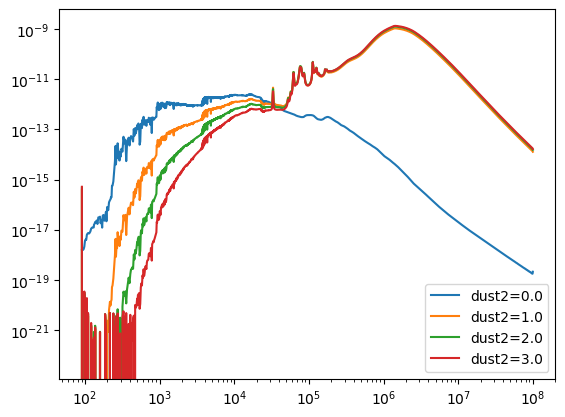

In [8]:

    for n, spec in enumerate(specs):
        loglog(wspec, spec, label=f'dust2={dusts[n]}')
    
    legend()
    show()

In [5]:
import itertools

In [ ]:
N = 4 # Number of plots we're making to test

 # tqdm(itertools.product(range(len(logzs)),range(len(dusts)),range(len(tages)))):

fbursts = np.logspace(-2,0,25)
dusts = np.linspace(0,3,4)
# print(fbursts)

specs = np.empty((len(dusts),len(fbursts),len(wspec)))

for i_fburst, i_dust in tqdm(itertools.product(range(len(fbursts)), range(len(dusts)))):
    run_params['fburst'], run_params['const'] = fbursts[i_fburst], .8 - fbursts[i_fburst]
    run_params['dust2'] = dusts[i_dust]
    model = model_function(**run_params)
    spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
    specs[i_dust,i_fburst,:] = spec
    print(dusts[i_dust], fbursts[i_fburst])
print('done')

[0.01       0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1        0.12115277 0.14677993 0.17782794 0.21544347 0.26101572
 0.31622777 0.38311868 0.46415888 0.56234133 0.68129207 0.82540419
 1.        ]


12it [00:53,  3.18s/it]

0.0 0.01
1.0 0.01
2.0 0.01
3.0 0.01
0.0 0.012115276586285882
1.0 0.012115276586285882
2.0 0.012115276586285882
3.0 0.012115276586285882
0.0 0.014677992676220698
1.0 0.014677992676220698
2.0 0.014677992676220698
3.0 0.014677992676220698
0.0 0.01778279410038923
1.0 0.01778279410038923
2.0 0.01778279410038923
3.0 0.01778279410038923
0.0 0.021544346900318832
1.0 0.021544346900318832
2.0 0.021544346900318832
3.0 0.021544346900318832
0.0 0.026101572156825358


34it [00:53,  1.33it/s]

1.0 0.026101572156825358
2.0 0.026101572156825358
3.0 0.026101572156825358
0.0 0.03162277660168379
1.0 0.03162277660168379
2.0 0.03162277660168379
3.0 0.03162277660168379
0.0 0.03831186849557287
1.0 0.03831186849557287
2.0 0.03831186849557287
3.0 0.03831186849557287
0.0 0.046415888336127774
1.0 0.046415888336127774
2.0 0.046415888336127774
3.0 0.046415888336127774
0.0 0.056234132519034905
1.0 0.056234132519034905
2.0 0.056234132519034905
3.0 0.056234132519034905
0.0 0.06812920690579612


54it [00:53,  3.15it/s]

1.0 0.06812920690579612
2.0 0.06812920690579612
3.0 0.06812920690579612
0.0 0.08254041852680181
1.0 0.08254041852680181
2.0 0.08254041852680181
3.0 0.08254041852680181
0.0 0.1
1.0 0.1
2.0 0.1
3.0 0.1
0.0 0.12115276586285882
1.0 0.12115276586285882
2.0 0.12115276586285882
3.0 0.12115276586285882
0.0 0.1467799267622069
1.0 0.1467799267622069
2.0 0.1467799267622069
3.0 0.1467799267622069
0.0 0.1778279410038923
1.0 0.1778279410038923


75it [00:53,  6.82it/s]

2.0 0.1778279410038923
3.0 0.1778279410038923
0.0 0.21544346900318834
1.0 0.21544346900318834
2.0 0.21544346900318834
3.0 0.21544346900318834
0.0 0.2610157215682536
1.0 0.2610157215682536
2.0 0.2610157215682536
3.0 0.2610157215682536
0.0 0.31622776601683794
1.0 0.31622776601683794
2.0 0.31622776601683794
3.0 0.31622776601683794
0.0 0.3831186849557287
1.0 0.3831186849557287
2.0 0.3831186849557287
3.0 0.3831186849557287
0.0 0.46415888336127775
1.0 0.46415888336127775
2.0 0.46415888336127775


86it [00:53,  9.85it/s]

In [1]:
i_dust = 0

for i_fburst in range(len(fbursts)):
    loglog(wspec, specs[i_dust, i_fburst,:], label=f'fburst={fbursts[i_fburst]}')

legend()

NameError: name 'fbursts' is not defined

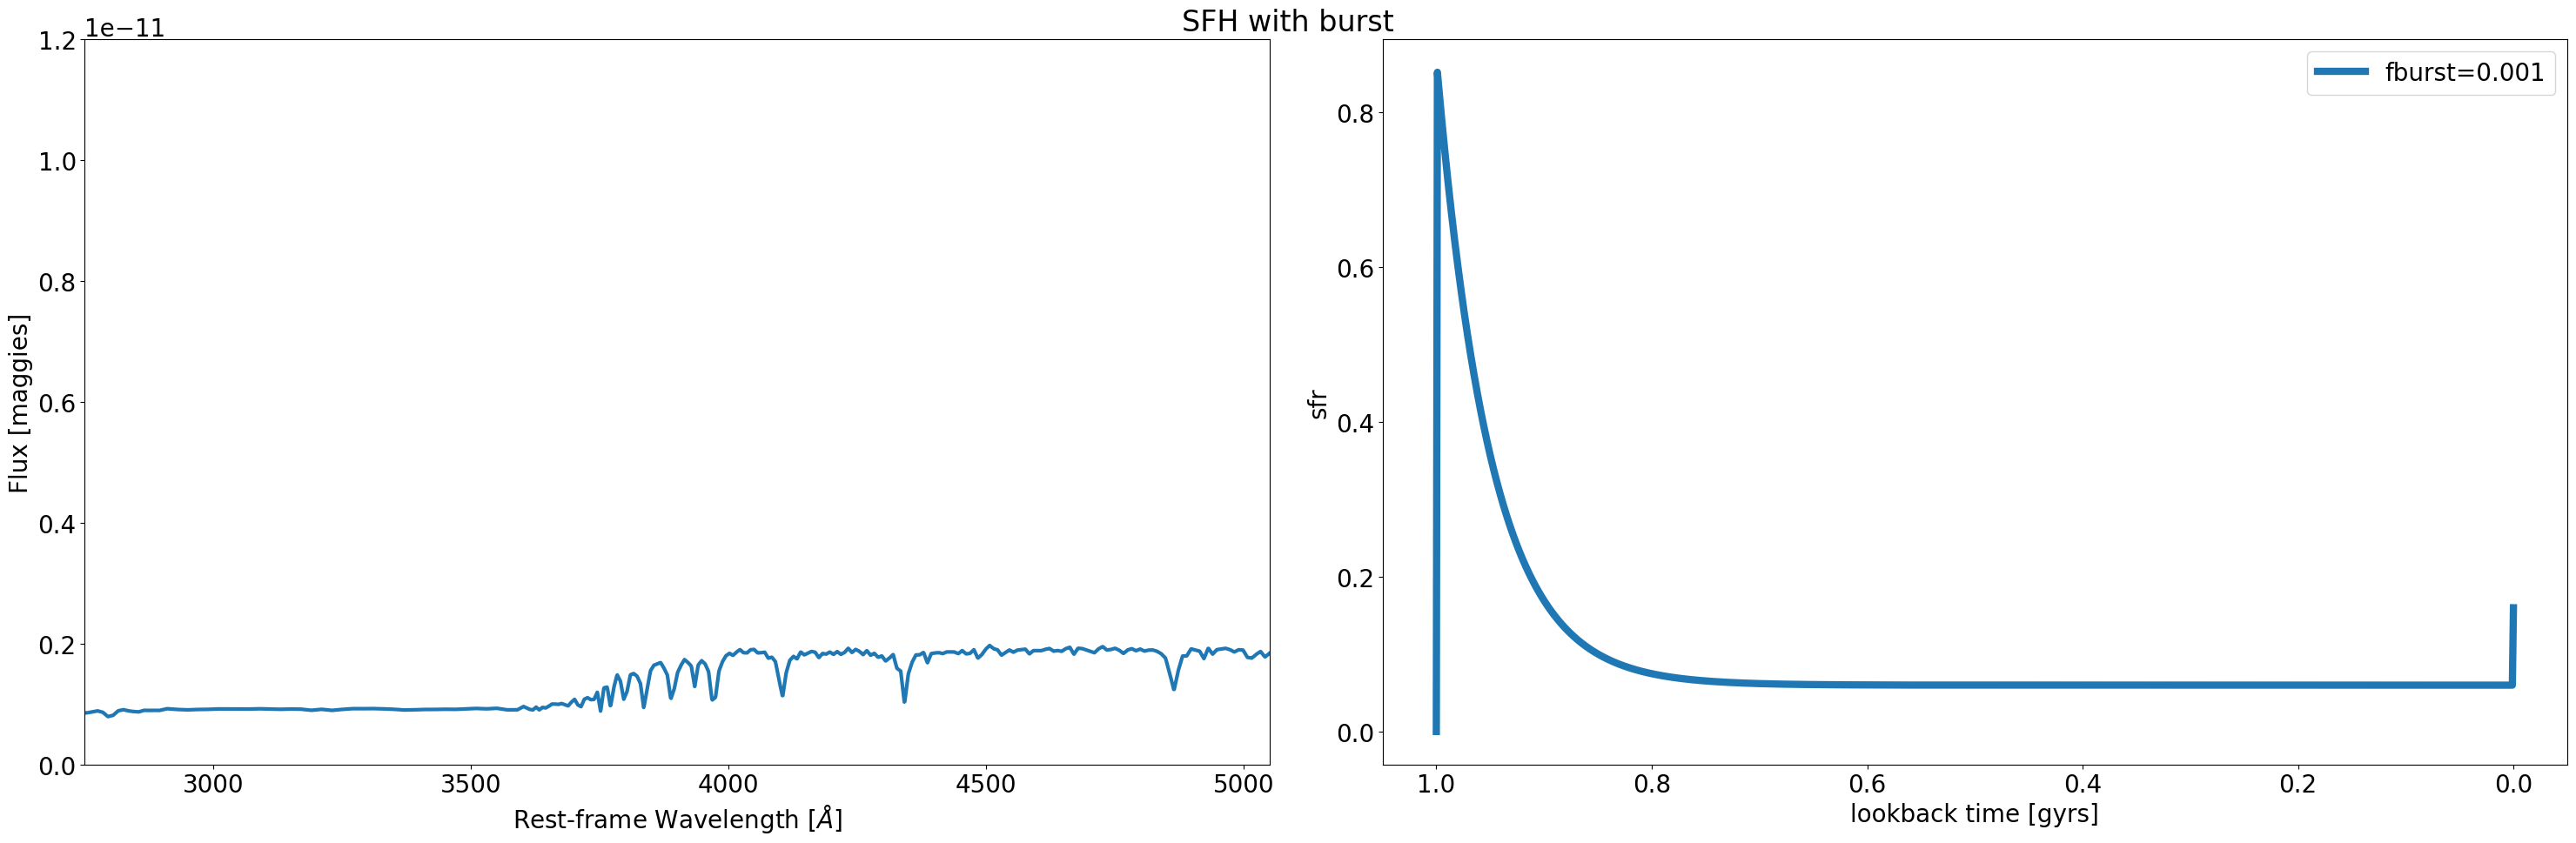

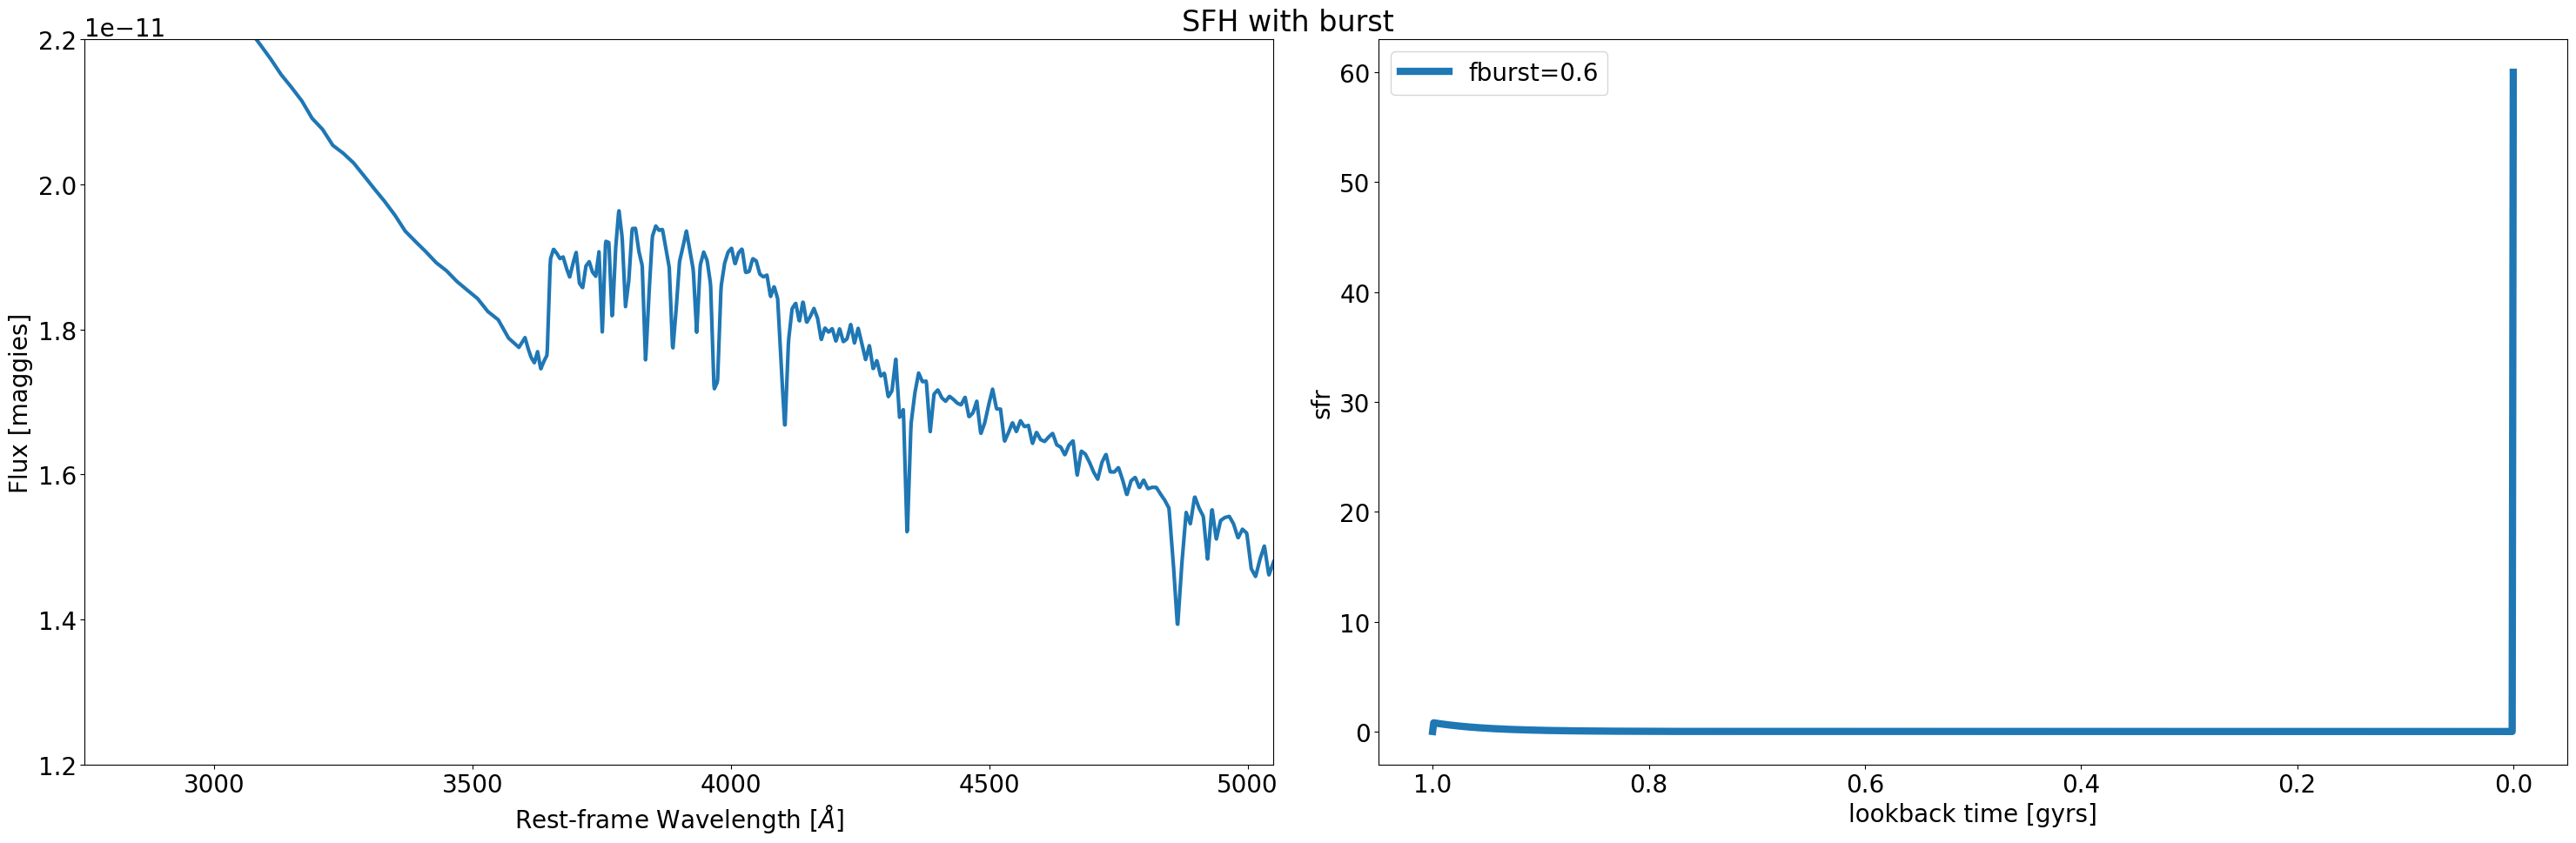

In [267]:
times = np.linspace(0,run_params['tage'],1000)

rcParams['font.size'] = 20

# fig, [ax1,ax2] = subplots(1,2,figsize=(28*2,7*2))
n=1
for spec, f in zip(specs, fbursts):

    fig, [ax1,ax2] = subplots(1,2,figsize=(30,10))
    ax1.plot(wspec, spec, lw=3)
    ax1.set_xlabel(r'Rest-frame Wavelength [$\AA$]')
    ax1.set_ylabel('Flux [maggies]')
    ax1.set_xlim([2750,5050])
    if n==1:
        ax1.set_ylim([0.0,1.2e-11])
    elif n==2:
        ax1.set_ylim([1.2e-11,2.2e-11])
    # ax1.set_yscale('log')

    run_params['fburst'], run_params['const'] = f, .6 - f

    # print(run_params)
    sfrs = parametric_sfr(times=times,**run_params)
    
    ax2.plot(times,sfrs, lw=6, label=f'fburst={f}')
    ax2.set_xlabel('lookback time [gyrs]')
    ax2.set_ylabel('sfr')
    ax2.set_xlim([times[-1]+.05,times[0]-.05])

    ax2.legend()

    tight_layout()
    fig.suptitle(f'SFH with burst')
    n+=1
    
    # savefig(f'check_{n}.png')

show()

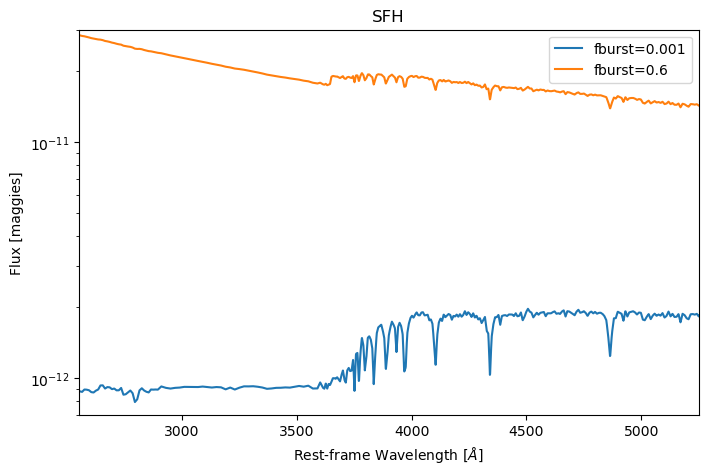

In [291]:
rcParams['font.size'] = 10
figure(figsize=(8,5))

for n,spec in enumerate(specs):
    loglog(wspec, spec, label=f'fburst={fbursts[n]}')

xscale('linear')
xlim([2550,5250])
ylim([7.0e-13,3.0e-11])

xlabel(r'Rest-frame Wavelength [$\AA$]')
ylabel('Flux [maggies]')

title('SFH')
legend()

show()

--------------------


#### TESTING


---------------------

In [ ]:
for spec, f in zip(specs, fbursts):

    fig, [ax1,ax2] = subplots(1,2,figsize=(28,7))
    ax1.loglog(wspec, spec)
    ax1.set_xlabel(r'Rest-frame Wavelength [$\AA$]')
    ax1.set_ylabel('Flux [maggies]')

    run_params['fburst'] = f

    print(run_params)
    sfrs = parametric_sfr(times=times,**run_params)
    
    ax2.plot(times,sfrs, label=f'fburst={f}')
    ax2.set_xlabel('lookback time [gyrs]')
    ax2.set_ylabel('sfr')
    ax2.set_xlim([times[-1],times[0]])
    ax2.set_title('SFH')

    ax2.legend()

    show()